In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"akshmahee","key":"43f2213a6e91296bdd9c20808afed440"}'}

In [2]:
import os
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d jessicali9530/celeba-dataset

Dataset URL: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
License(s): other
 99% 1.32G/1.33G [00:08<00:00, 261MB/s]
100% 1.33G/1.33G [00:08<00:00, 174MB/s]


In [4]:
import zipfile
zip_ref = zipfile.ZipFile('/content/celeba-dataset.zip')
zip_ref.extractall('/content')
zip_ref.close()

In [5]:
import torch
import numpy as np

In [6]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

class celebdata(Dataset):
  def __init__(self,root_dir,transform=None):
    self.root_dir = root_dir
    self.transform = transform
    self.image_paths = [os.path.join(root_dir,img) for img in os.listdir(root_dir) if img.endswith('.jpg')]

  def __len__(self):
    return len(self.image_paths)
  def __getitem__(self, index):
    img_path = self.image_paths[index]
    image = Image.open(img_path).convert('RGB')
    if self.transform:
      image = self.transform(image)
    return image


In [7]:
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5],std = [0.5,0.5,0.5])
])
dataset_path = "/content/img_align_celeba/img_align_celeba"
dataset = celebdata(root_dir = dataset_path,transform=transform)

In [8]:
dataloader = DataLoader(dataset,batch_size = 256, shuffle=True)
len(dataset)

202599

In [9]:
import matplotlib.pyplot as plt
import torchvision
import torch.nn as nn
import torch.optim as optim

In [11]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, z_dim=100, img_channels=3):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            # Input: (B, z_dim, 1, 1)
            nn.ConvTranspose2d(z_dim, 512, kernel_size=4, stride=1, padding=0),  # -> (B, 512, 4, 4)
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),    # -> (B, 256, 8, 8)
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),    # -> (B, 128, 16, 16)
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),     # -> (B, 64, 32, 32)
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, img_channels, kernel_size=4, stride=2, padding=1),  # -> (B, 3, 64, 64)
            nn.Tanh()
        )

    def forward(self, z):
        # z: (B, z_dim)
        z = z.view(z.size(0), z.size(1), 1, 1)  # Reshape to (B, z_dim, 1, 1)
        return self.model(z)


In [12]:
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self, img_channels=3):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            # Input: (B, 3, 64, 64)
            nn.Conv2d(img_channels, 64, kernel_size=4, stride=2, padding=1),   # -> (B, 64, 32, 32)
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),            # -> (B, 128, 16, 16)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),           # -> (B, 256, 8, 8)
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),           # -> (B, 512, 4, 4)
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0),             # -> (B, 1, 1, 1)
            nn.Sigmoid()  # Outputs probability real/fake
        )

    def forward(self, x):
        out = self.model(x)
        return out.view(-1, 1)  # Flatten to (B, 1)


In [13]:
adversarial_loss = nn.BCELoss()
generator = Generator(z_dim=100)
discriminator = Discriminator()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
generator = generator.to(device)
discriminator = discriminator.to(device)

[Epoch 0/20] [Batch 0/792] [D loss: 0.7755245566368103] [G loss: 2.0102882385253906]
[Epoch 0/20] [Batch 50/792] [D loss: 0.13609910011291504] [G loss: 15.700605392456055]
[Epoch 0/20] [Batch 100/792] [D loss: 0.5893407464027405] [G loss: 1.6411893367767334]
[Epoch 0/20] [Batch 150/792] [D loss: 0.6942386031150818] [G loss: 5.267282962799072]
[Epoch 0/20] [Batch 200/792] [D loss: 0.6208332777023315] [G loss: 5.01663875579834]
[Epoch 0/20] [Batch 250/792] [D loss: 0.39445728063583374] [G loss: 2.6690449714660645]
[Epoch 0/20] [Batch 300/792] [D loss: 0.5399042963981628] [G loss: 3.961214065551758]
[Epoch 0/20] [Batch 350/792] [D loss: 0.2786550223827362] [G loss: 1.8420031070709229]
[Epoch 0/20] [Batch 400/792] [D loss: 0.2806992530822754] [G loss: 3.569213628768921]
[Epoch 0/20] [Batch 450/792] [D loss: 0.1998354196548462] [G loss: 2.8935256004333496]
[Epoch 0/20] [Batch 500/792] [D loss: 0.19974097609519958] [G loss: 3.008392810821533]
[Epoch 0/20] [Batch 550/792] [D loss: 0.293754756

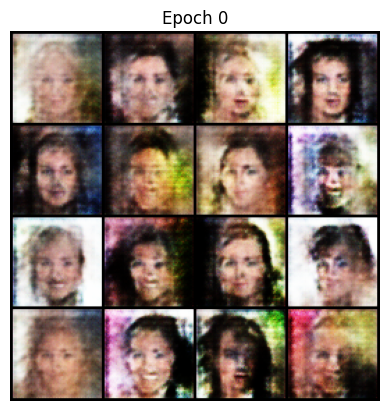

[Epoch 1/20] [Batch 0/792] [D loss: 0.21486203372478485] [G loss: 2.3907742500305176]
[Epoch 1/20] [Batch 50/792] [D loss: 0.2779034972190857] [G loss: 2.581617832183838]
[Epoch 1/20] [Batch 100/792] [D loss: 0.41407477855682373] [G loss: 1.6347846984863281]
[Epoch 1/20] [Batch 150/792] [D loss: 0.43170011043548584] [G loss: 5.157498836517334]
[Epoch 1/20] [Batch 200/792] [D loss: 0.4751778244972229] [G loss: 1.916524052619934]
[Epoch 1/20] [Batch 250/792] [D loss: 0.34312379360198975] [G loss: 2.022871494293213]
[Epoch 1/20] [Batch 300/792] [D loss: 0.37287068367004395] [G loss: 3.3050460815429688]
[Epoch 1/20] [Batch 350/792] [D loss: 0.2169581949710846] [G loss: 3.367305278778076]
[Epoch 1/20] [Batch 400/792] [D loss: 0.27152514457702637] [G loss: 2.399867534637451]
[Epoch 1/20] [Batch 450/792] [D loss: 0.32396653294563293] [G loss: 4.013606548309326]
[Epoch 1/20] [Batch 500/792] [D loss: 0.33817964792251587] [G loss: 2.464012384414673]
[Epoch 1/20] [Batch 550/792] [D loss: 0.640064

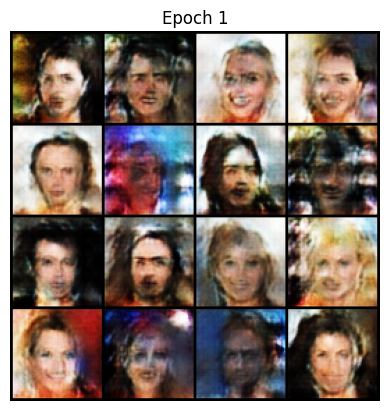

[Epoch 2/20] [Batch 0/792] [D loss: 0.3480081856250763] [G loss: 2.1539242267608643]
[Epoch 2/20] [Batch 50/792] [D loss: 0.21620088815689087] [G loss: 3.0293455123901367]
[Epoch 2/20] [Batch 100/792] [D loss: 0.2975994646549225] [G loss: 2.5234570503234863]
[Epoch 2/20] [Batch 150/792] [D loss: 0.2216736376285553] [G loss: 3.0066401958465576]
[Epoch 2/20] [Batch 200/792] [D loss: 0.19937968254089355] [G loss: 2.8796305656433105]
[Epoch 2/20] [Batch 250/792] [D loss: 0.1953423023223877] [G loss: 2.6830291748046875]
[Epoch 2/20] [Batch 300/792] [D loss: 0.2289658635854721] [G loss: 2.6570818424224854]
[Epoch 2/20] [Batch 350/792] [D loss: 0.19657446444034576] [G loss: 3.7273952960968018]
[Epoch 2/20] [Batch 400/792] [D loss: 0.2609707713127136] [G loss: 2.446612596511841]
[Epoch 2/20] [Batch 450/792] [D loss: 0.2735757827758789] [G loss: 3.805251121520996]
[Epoch 2/20] [Batch 500/792] [D loss: 0.23545321822166443] [G loss: 2.578324794769287]
[Epoch 2/20] [Batch 550/792] [D loss: 0.19447

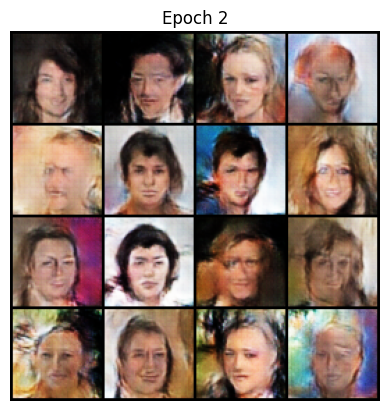

[Epoch 3/20] [Batch 0/792] [D loss: 0.40577030181884766] [G loss: 3.3553223609924316]
[Epoch 3/20] [Batch 50/792] [D loss: 0.18397420644760132] [G loss: 2.4422194957733154]
[Epoch 3/20] [Batch 100/792] [D loss: 0.25879910588264465] [G loss: 2.1171913146972656]
[Epoch 3/20] [Batch 150/792] [D loss: 0.18850433826446533] [G loss: 2.87569260597229]
[Epoch 3/20] [Batch 200/792] [D loss: 0.319744348526001] [G loss: 2.624922037124634]
[Epoch 3/20] [Batch 250/792] [D loss: 0.19437867403030396] [G loss: 2.5314369201660156]
[Epoch 3/20] [Batch 300/792] [D loss: 0.3421638011932373] [G loss: 2.7120361328125]
[Epoch 3/20] [Batch 350/792] [D loss: 0.27914348244667053] [G loss: 3.0174834728240967]
[Epoch 3/20] [Batch 400/792] [D loss: 0.2609691321849823] [G loss: 4.139279365539551]
[Epoch 3/20] [Batch 450/792] [D loss: 0.24256277084350586] [G loss: 3.1855628490448]
[Epoch 3/20] [Batch 500/792] [D loss: 0.27653342485427856] [G loss: 2.7063703536987305]
[Epoch 3/20] [Batch 550/792] [D loss: 0.220093876

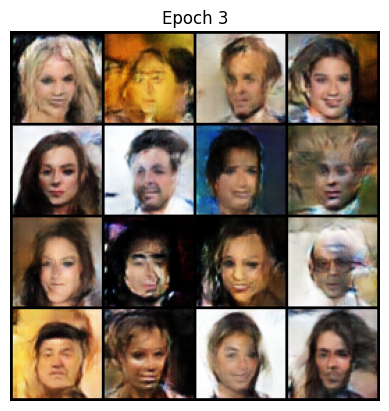

[Epoch 4/20] [Batch 0/792] [D loss: 0.20469719171524048] [G loss: 3.1833271980285645]
[Epoch 4/20] [Batch 50/792] [D loss: 0.22089701890945435] [G loss: 3.789684295654297]
[Epoch 4/20] [Batch 100/792] [D loss: 0.24990424513816833] [G loss: 3.668245315551758]
[Epoch 4/20] [Batch 150/792] [D loss: 0.17453831434249878] [G loss: 2.014347553253174]
[Epoch 4/20] [Batch 200/792] [D loss: 0.5126254558563232] [G loss: 4.886588096618652]
[Epoch 4/20] [Batch 250/792] [D loss: 0.7477697134017944] [G loss: 6.359529495239258]
[Epoch 4/20] [Batch 300/792] [D loss: 0.17034560441970825] [G loss: 2.075498580932617]
[Epoch 4/20] [Batch 350/792] [D loss: 0.1461493819952011] [G loss: 2.8489489555358887]
[Epoch 4/20] [Batch 400/792] [D loss: 0.1776064932346344] [G loss: 2.9796974658966064]
[Epoch 4/20] [Batch 450/792] [D loss: 0.2219754159450531] [G loss: 2.8205175399780273]
[Epoch 4/20] [Batch 500/792] [D loss: 0.19852489233016968] [G loss: 2.8192362785339355]
[Epoch 4/20] [Batch 550/792] [D loss: 0.198325

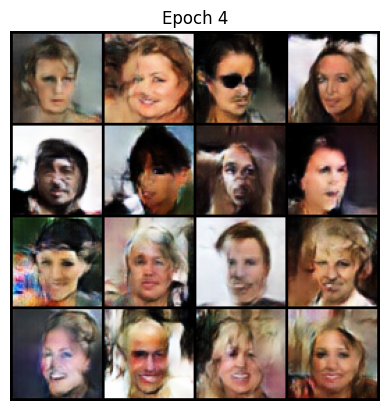

[Epoch 5/20] [Batch 0/792] [D loss: 0.1206180676817894] [G loss: 2.5167384147644043]
[Epoch 5/20] [Batch 50/792] [D loss: 0.1478652060031891] [G loss: 2.2562029361724854]
[Epoch 5/20] [Batch 100/792] [D loss: 0.1637578308582306] [G loss: 2.329659938812256]
[Epoch 5/20] [Batch 150/792] [D loss: 0.08600436896085739] [G loss: 4.358442306518555]
[Epoch 5/20] [Batch 200/792] [D loss: 0.5018299221992493] [G loss: 5.848424434661865]
[Epoch 5/20] [Batch 250/792] [D loss: 0.250297486782074] [G loss: 3.6098904609680176]
[Epoch 5/20] [Batch 300/792] [D loss: 0.24898691475391388] [G loss: 1.6982252597808838]
[Epoch 5/20] [Batch 350/792] [D loss: 0.5820503830909729] [G loss: 2.6375715732574463]
[Epoch 5/20] [Batch 400/792] [D loss: 0.3056637644767761] [G loss: 3.339280605316162]
[Epoch 5/20] [Batch 450/792] [D loss: 0.19577646255493164] [G loss: 3.243781089782715]
[Epoch 5/20] [Batch 500/792] [D loss: 0.11194060742855072] [G loss: 3.6177003383636475]
[Epoch 5/20] [Batch 550/792] [D loss: 0.23279505

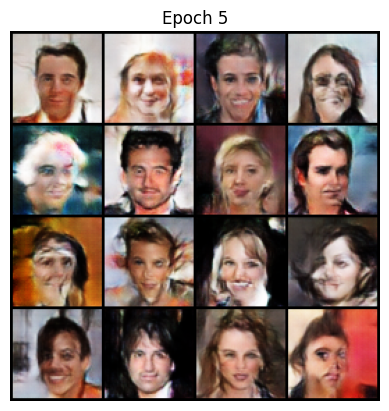

[Epoch 6/20] [Batch 0/792] [D loss: 0.1437363177537918] [G loss: 4.214353084564209]
[Epoch 6/20] [Batch 50/792] [D loss: 0.08098170161247253] [G loss: 3.0762863159179688]
[Epoch 6/20] [Batch 100/792] [D loss: 0.09657042473554611] [G loss: 4.040985107421875]
[Epoch 6/20] [Batch 150/792] [D loss: 0.37334686517715454] [G loss: 5.911432266235352]
[Epoch 6/20] [Batch 200/792] [D loss: 0.16890203952789307] [G loss: 3.9275360107421875]
[Epoch 6/20] [Batch 250/792] [D loss: 0.8957890868186951] [G loss: 8.495638847351074]
[Epoch 6/20] [Batch 300/792] [D loss: 0.08008183538913727] [G loss: 3.4245848655700684]
[Epoch 6/20] [Batch 350/792] [D loss: 0.08004727959632874] [G loss: 3.659175395965576]
[Epoch 6/20] [Batch 400/792] [D loss: 0.10970357060432434] [G loss: 3.7435505390167236]
[Epoch 6/20] [Batch 450/792] [D loss: 0.12588243186473846] [G loss: 2.934981346130371]
[Epoch 6/20] [Batch 500/792] [D loss: 0.24283400177955627] [G loss: 1.1226599216461182]
[Epoch 6/20] [Batch 550/792] [D loss: 0.115

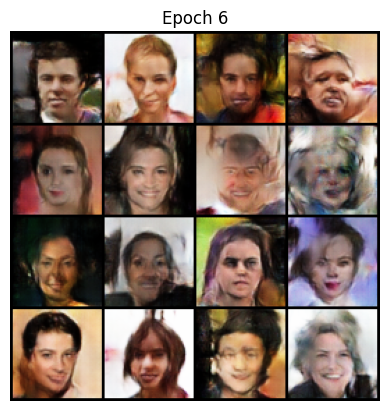

[Epoch 7/20] [Batch 0/792] [D loss: 0.5229612588882446] [G loss: 1.2956278324127197]
[Epoch 7/20] [Batch 50/792] [D loss: 0.19988864660263062] [G loss: 3.085890769958496]
[Epoch 7/20] [Batch 100/792] [D loss: 0.41417622566223145] [G loss: 4.370712757110596]
[Epoch 7/20] [Batch 150/792] [D loss: 0.10002654790878296] [G loss: 3.6435251235961914]
[Epoch 7/20] [Batch 200/792] [D loss: 0.15149424970149994] [G loss: 3.185263156890869]
[Epoch 7/20] [Batch 250/792] [D loss: 0.30166590213775635] [G loss: 2.2048075199127197]
[Epoch 7/20] [Batch 300/792] [D loss: 0.43045222759246826] [G loss: 1.4777312278747559]
[Epoch 7/20] [Batch 350/792] [D loss: 0.10114604234695435] [G loss: 3.107388973236084]
[Epoch 7/20] [Batch 400/792] [D loss: 0.5980762243270874] [G loss: 0.9706234931945801]
[Epoch 7/20] [Batch 450/792] [D loss: 0.08750159293413162] [G loss: 3.5225610733032227]
[Epoch 7/20] [Batch 500/792] [D loss: 0.26557666063308716] [G loss: 3.335324287414551]
[Epoch 7/20] [Batch 550/792] [D loss: 0.06

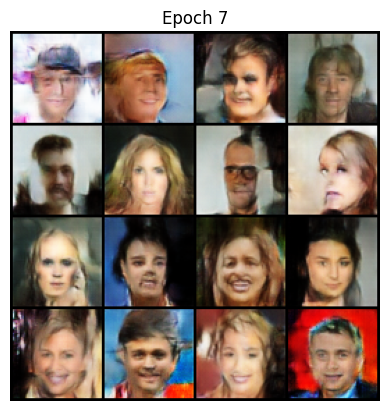

[Epoch 8/20] [Batch 0/792] [D loss: 0.23064075410366058] [G loss: 4.451456069946289]
[Epoch 8/20] [Batch 50/792] [D loss: 0.18422167003154755] [G loss: 2.4126553535461426]
[Epoch 8/20] [Batch 100/792] [D loss: 0.3736603856086731] [G loss: 5.028149604797363]
[Epoch 8/20] [Batch 150/792] [D loss: 0.10469511151313782] [G loss: 4.02163028717041]
[Epoch 8/20] [Batch 200/792] [D loss: 0.06823806464672089] [G loss: 3.0103702545166016]
[Epoch 8/20] [Batch 250/792] [D loss: 0.6757630109786987] [G loss: 1.7096809148788452]
[Epoch 8/20] [Batch 300/792] [D loss: 0.4385041296482086] [G loss: 1.359005093574524]
[Epoch 8/20] [Batch 350/792] [D loss: 0.07185722142457962] [G loss: 3.287917137145996]
[Epoch 8/20] [Batch 400/792] [D loss: 0.1504998356103897] [G loss: 4.171358108520508]
[Epoch 8/20] [Batch 450/792] [D loss: 0.23342561721801758] [G loss: 5.011197090148926]
[Epoch 8/20] [Batch 500/792] [D loss: 0.08084224164485931] [G loss: 3.3854758739471436]
[Epoch 8/20] [Batch 550/792] [D loss: 0.1936449

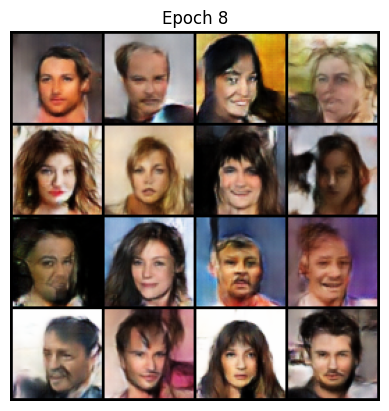

[Epoch 9/20] [Batch 0/792] [D loss: 0.10558395087718964] [G loss: 3.9511733055114746]
[Epoch 9/20] [Batch 50/792] [D loss: 0.046809494495391846] [G loss: 3.34202241897583]
[Epoch 9/20] [Batch 100/792] [D loss: 0.057580385357141495] [G loss: 3.956301689147949]
[Epoch 9/20] [Batch 150/792] [D loss: 0.17290282249450684] [G loss: 5.136981010437012]
[Epoch 9/20] [Batch 200/792] [D loss: 0.1534658670425415] [G loss: 2.980750560760498]
[Epoch 9/20] [Batch 250/792] [D loss: 0.10110878199338913] [G loss: 3.6072661876678467]
[Epoch 9/20] [Batch 300/792] [D loss: 0.38216865062713623] [G loss: 5.4670867919921875]
[Epoch 9/20] [Batch 350/792] [D loss: 0.8986217379570007] [G loss: 0.5982033610343933]
[Epoch 9/20] [Batch 400/792] [D loss: 0.0712941586971283] [G loss: 3.6267552375793457]
[Epoch 9/20] [Batch 450/792] [D loss: 0.06174253672361374] [G loss: 2.9598171710968018]
[Epoch 9/20] [Batch 500/792] [D loss: 0.12072990089654922] [G loss: 2.846353054046631]
[Epoch 9/20] [Batch 550/792] [D loss: 0.08

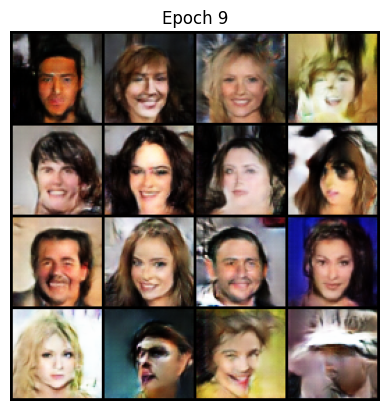

[Epoch 10/20] [Batch 0/792] [D loss: 0.08001294732093811] [G loss: 4.010507106781006]
[Epoch 10/20] [Batch 50/792] [D loss: 0.07360976934432983] [G loss: 3.919360637664795]
[Epoch 10/20] [Batch 100/792] [D loss: 0.1016094759106636] [G loss: 3.7057948112487793]
[Epoch 10/20] [Batch 150/792] [D loss: 0.20977889001369476] [G loss: 2.830111026763916]
[Epoch 10/20] [Batch 200/792] [D loss: 0.43113425374031067] [G loss: 3.6700921058654785]
[Epoch 10/20] [Batch 250/792] [D loss: 0.09154035896062851] [G loss: 2.7199501991271973]
[Epoch 10/20] [Batch 300/792] [D loss: 0.07154755294322968] [G loss: 4.596151351928711]
[Epoch 10/20] [Batch 350/792] [D loss: 0.15329495072364807] [G loss: 3.4053118228912354]
[Epoch 10/20] [Batch 400/792] [D loss: 0.07430320233106613] [G loss: 3.525885820388794]
[Epoch 10/20] [Batch 450/792] [D loss: 0.07876843214035034] [G loss: 3.7296581268310547]
[Epoch 10/20] [Batch 500/792] [D loss: 0.2892105281352997] [G loss: 3.3449361324310303]
[Epoch 10/20] [Batch 550/792] [

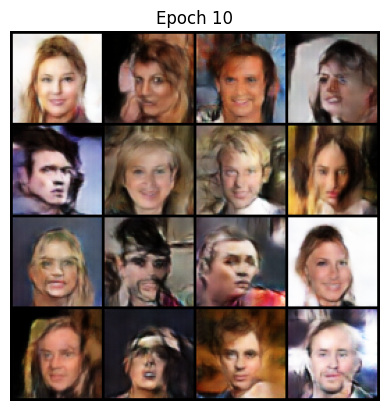

[Epoch 11/20] [Batch 0/792] [D loss: 0.07886028289794922] [G loss: 3.8212552070617676]
[Epoch 11/20] [Batch 50/792] [D loss: 0.2991495728492737] [G loss: 2.367307424545288]
[Epoch 11/20] [Batch 100/792] [D loss: 0.08342193067073822] [G loss: 2.424562454223633]
[Epoch 11/20] [Batch 150/792] [D loss: 0.2949151396751404] [G loss: 1.8685460090637207]
[Epoch 11/20] [Batch 200/792] [D loss: 0.10078836977481842] [G loss: 3.6979928016662598]
[Epoch 11/20] [Batch 250/792] [D loss: 0.056706950068473816] [G loss: 3.567469835281372]
[Epoch 11/20] [Batch 300/792] [D loss: 0.09944213926792145] [G loss: 3.299703598022461]
[Epoch 11/20] [Batch 350/792] [D loss: 0.044979993253946304] [G loss: 3.2664546966552734]
[Epoch 11/20] [Batch 400/792] [D loss: 0.38345009088516235] [G loss: 4.54847526550293]
[Epoch 11/20] [Batch 450/792] [D loss: 0.0850980281829834] [G loss: 3.6211423873901367]
[Epoch 11/20] [Batch 500/792] [D loss: 0.11444544047117233] [G loss: 3.7162601947784424]
[Epoch 11/20] [Batch 550/792] [

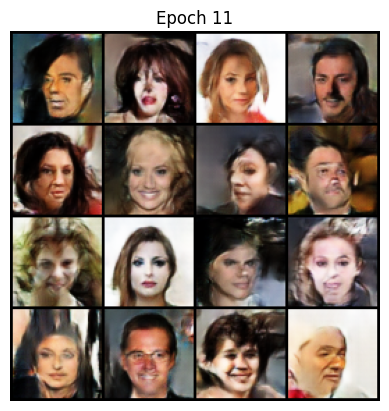

[Epoch 12/20] [Batch 0/792] [D loss: 0.04438736289739609] [G loss: 3.47868275642395]
[Epoch 12/20] [Batch 50/792] [D loss: 0.8752517104148865] [G loss: 9.167618751525879]
[Epoch 12/20] [Batch 100/792] [D loss: 0.06957067549228668] [G loss: 3.670222759246826]
[Epoch 12/20] [Batch 150/792] [D loss: 0.3487245738506317] [G loss: 1.0572987794876099]
[Epoch 12/20] [Batch 200/792] [D loss: 0.06234697997570038] [G loss: 4.377411842346191]
[Epoch 12/20] [Batch 250/792] [D loss: 0.16936400532722473] [G loss: 6.078526973724365]
[Epoch 12/20] [Batch 300/792] [D loss: 0.09218677878379822] [G loss: 3.0094032287597656]
[Epoch 12/20] [Batch 350/792] [D loss: 0.05450071021914482] [G loss: 3.0611047744750977]
[Epoch 12/20] [Batch 400/792] [D loss: 0.05798680707812309] [G loss: 4.133256912231445]
[Epoch 12/20] [Batch 450/792] [D loss: 0.05241754651069641] [G loss: 2.6868183612823486]
[Epoch 12/20] [Batch 500/792] [D loss: 0.051888175308704376] [G loss: 3.7203149795532227]
[Epoch 12/20] [Batch 550/792] [D

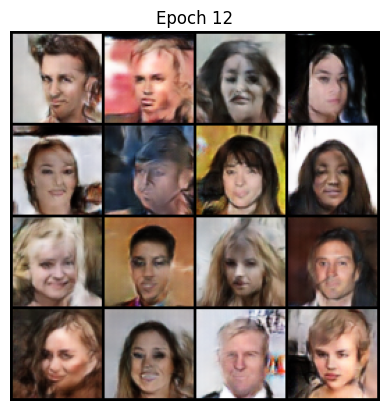

[Epoch 13/20] [Batch 0/792] [D loss: 0.07065046578645706] [G loss: 2.7203547954559326]
[Epoch 13/20] [Batch 50/792] [D loss: 0.0641869381070137] [G loss: 4.107031345367432]
[Epoch 13/20] [Batch 100/792] [D loss: 0.050422027707099915] [G loss: 3.953711986541748]
[Epoch 13/20] [Batch 150/792] [D loss: 0.043449077755212784] [G loss: 3.620124340057373]
[Epoch 13/20] [Batch 200/792] [D loss: 0.17707568407058716] [G loss: 2.9854979515075684]
[Epoch 13/20] [Batch 250/792] [D loss: 0.25959867238998413] [G loss: 9.83610725402832]
[Epoch 13/20] [Batch 300/792] [D loss: 0.13909760117530823] [G loss: 5.619979381561279]
[Epoch 13/20] [Batch 350/792] [D loss: 0.09220458567142487] [G loss: 3.396841049194336]
[Epoch 13/20] [Batch 400/792] [D loss: 0.06190738081932068] [G loss: 4.139881134033203]
[Epoch 13/20] [Batch 450/792] [D loss: 0.16927684843540192] [G loss: 4.225495338439941]
[Epoch 13/20] [Batch 500/792] [D loss: 0.0509386844933033] [G loss: 4.324289321899414]
[Epoch 13/20] [Batch 550/792] [D l

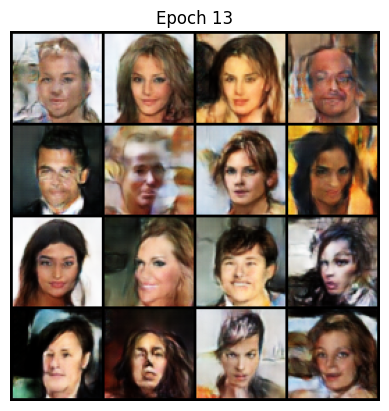

[Epoch 14/20] [Batch 0/792] [D loss: 0.5310306549072266] [G loss: 1.1831626892089844]
[Epoch 14/20] [Batch 50/792] [D loss: 0.04001692682504654] [G loss: 4.632185459136963]
[Epoch 14/20] [Batch 100/792] [D loss: 0.06589769572019577] [G loss: 5.4721503257751465]
[Epoch 14/20] [Batch 150/792] [D loss: 0.06507255136966705] [G loss: 2.6725666522979736]
[Epoch 14/20] [Batch 200/792] [D loss: 2.3136796951293945] [G loss: 0.1683688759803772]
[Epoch 14/20] [Batch 250/792] [D loss: 0.14133289456367493] [G loss: 3.648944616317749]
[Epoch 14/20] [Batch 300/792] [D loss: 0.21331875026226044] [G loss: 5.445247650146484]
[Epoch 14/20] [Batch 350/792] [D loss: 0.08419275283813477] [G loss: 3.838611125946045]
[Epoch 14/20] [Batch 400/792] [D loss: 0.041758909821510315] [G loss: 4.568779468536377]
[Epoch 14/20] [Batch 450/792] [D loss: 0.10461051762104034] [G loss: 2.7064762115478516]
[Epoch 14/20] [Batch 500/792] [D loss: 0.05890577286481857] [G loss: 4.676456451416016]
[Epoch 14/20] [Batch 550/792] [

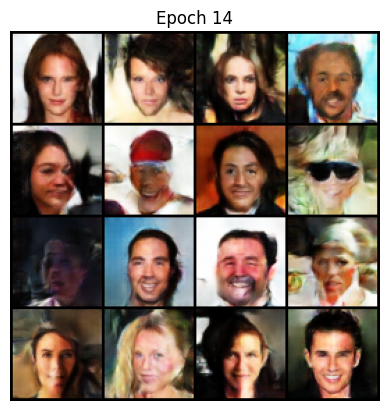

[Epoch 15/20] [Batch 0/792] [D loss: 0.14538168907165527] [G loss: 7.521932601928711]
[Epoch 15/20] [Batch 50/792] [D loss: 0.05464713275432587] [G loss: 3.5784783363342285]
[Epoch 15/20] [Batch 100/792] [D loss: 0.06212713569402695] [G loss: 3.2960093021392822]
[Epoch 15/20] [Batch 150/792] [D loss: 0.03435508906841278] [G loss: 3.9954447746276855]
[Epoch 15/20] [Batch 200/792] [D loss: 0.1068168506026268] [G loss: 2.158752918243408]
[Epoch 15/20] [Batch 250/792] [D loss: 0.11757122725248337] [G loss: 2.2343266010284424]
[Epoch 15/20] [Batch 300/792] [D loss: 0.1631796658039093] [G loss: 5.072662353515625]
[Epoch 15/20] [Batch 350/792] [D loss: 0.13854637742042542] [G loss: 0.9542793035507202]
[Epoch 15/20] [Batch 400/792] [D loss: 0.0741342082619667] [G loss: 3.314147472381592]
[Epoch 15/20] [Batch 450/792] [D loss: 0.2513872981071472] [G loss: 3.6978025436401367]
[Epoch 15/20] [Batch 500/792] [D loss: 0.13560587167739868] [G loss: 3.82665753364563]
[Epoch 15/20] [Batch 550/792] [D l

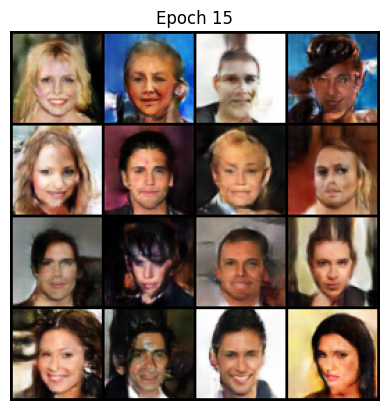

[Epoch 16/20] [Batch 0/792] [D loss: 0.10351628065109253] [G loss: 2.800938606262207]
[Epoch 16/20] [Batch 50/792] [D loss: 0.02867051213979721] [G loss: 5.57382869720459]
[Epoch 16/20] [Batch 100/792] [D loss: 0.37961235642433167] [G loss: 3.6055259704589844]
[Epoch 16/20] [Batch 150/792] [D loss: 0.5993762612342834] [G loss: 2.9507079124450684]
[Epoch 16/20] [Batch 200/792] [D loss: 0.7646592855453491] [G loss: 7.474291801452637]
[Epoch 16/20] [Batch 250/792] [D loss: 0.07643897086381912] [G loss: 4.711795330047607]
[Epoch 16/20] [Batch 300/792] [D loss: 0.05085930973291397] [G loss: 3.301572322845459]
[Epoch 16/20] [Batch 350/792] [D loss: 0.043507903814315796] [G loss: 3.4490227699279785]
[Epoch 16/20] [Batch 400/792] [D loss: 0.21105022728443146] [G loss: 1.9503037929534912]
[Epoch 16/20] [Batch 450/792] [D loss: 0.03355107083916664] [G loss: 4.692716598510742]
[Epoch 16/20] [Batch 500/792] [D loss: 0.17144273221492767] [G loss: 6.245601654052734]
[Epoch 16/20] [Batch 550/792] [D 

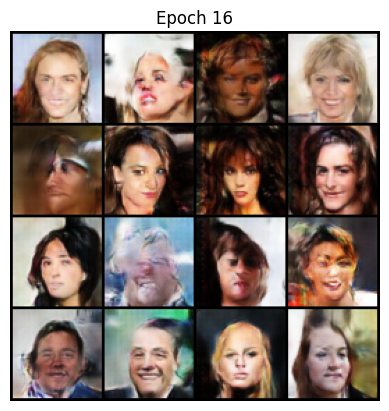

[Epoch 17/20] [Batch 0/792] [D loss: 0.13414013385772705] [G loss: 3.3191351890563965]
[Epoch 17/20] [Batch 50/792] [D loss: 0.04170197993516922] [G loss: 4.590414047241211]
[Epoch 17/20] [Batch 100/792] [D loss: 0.20282715559005737] [G loss: 4.266088485717773]
[Epoch 17/20] [Batch 150/792] [D loss: 0.6022657752037048] [G loss: 1.1560413837432861]
[Epoch 17/20] [Batch 200/792] [D loss: 0.09033221006393433] [G loss: 3.171854019165039]
[Epoch 17/20] [Batch 250/792] [D loss: 0.05297505483031273] [G loss: 3.6388769149780273]
[Epoch 17/20] [Batch 300/792] [D loss: 0.07360344380140305] [G loss: 2.676222324371338]
[Epoch 17/20] [Batch 350/792] [D loss: 0.0440291166305542] [G loss: 3.3418197631835938]
[Epoch 17/20] [Batch 400/792] [D loss: 0.07357195019721985] [G loss: 4.806879997253418]
[Epoch 17/20] [Batch 450/792] [D loss: 0.045744962990283966] [G loss: 3.4506850242614746]
[Epoch 17/20] [Batch 500/792] [D loss: 0.033294178545475006] [G loss: 3.549858570098877]
[Epoch 17/20] [Batch 550/792] 

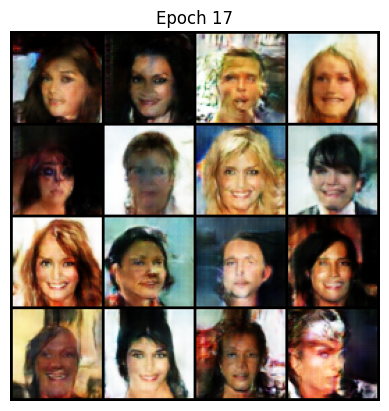

[Epoch 18/20] [Batch 0/792] [D loss: 0.22529008984565735] [G loss: 2.3793396949768066]
[Epoch 18/20] [Batch 50/792] [D loss: 0.10210184752941132] [G loss: 3.1194753646850586]
[Epoch 18/20] [Batch 100/792] [D loss: 0.18059810996055603] [G loss: 4.141313552856445]
[Epoch 18/20] [Batch 150/792] [D loss: 0.03810771554708481] [G loss: 4.29915714263916]
[Epoch 18/20] [Batch 200/792] [D loss: 0.03235219419002533] [G loss: 4.8357062339782715]
[Epoch 18/20] [Batch 250/792] [D loss: 0.13272784650325775] [G loss: 2.8997316360473633]
[Epoch 18/20] [Batch 300/792] [D loss: 0.13712185621261597] [G loss: 2.8017892837524414]
[Epoch 18/20] [Batch 350/792] [D loss: 0.03787868469953537] [G loss: 4.343022346496582]
[Epoch 18/20] [Batch 400/792] [D loss: 0.04235287755727768] [G loss: 4.280923843383789]
[Epoch 18/20] [Batch 450/792] [D loss: 0.04383289813995361] [G loss: 4.055005073547363]
[Epoch 18/20] [Batch 500/792] [D loss: 0.19559833407402039] [G loss: 2.7453019618988037]
[Epoch 18/20] [Batch 550/792] 

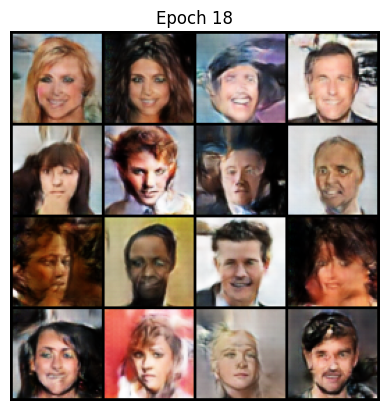

[Epoch 19/20] [Batch 0/792] [D loss: 0.12481662631034851] [G loss: 3.4100754261016846]
[Epoch 19/20] [Batch 50/792] [D loss: 0.08343766629695892] [G loss: 3.576078176498413]
[Epoch 19/20] [Batch 100/792] [D loss: 0.03792576491832733] [G loss: 4.539575099945068]
[Epoch 19/20] [Batch 150/792] [D loss: 0.048121917992830276] [G loss: 4.507957458496094]
[Epoch 19/20] [Batch 200/792] [D loss: 0.04083242267370224] [G loss: 3.027916669845581]
[Epoch 19/20] [Batch 250/792] [D loss: 0.04440389573574066] [G loss: 5.276708602905273]
[Epoch 19/20] [Batch 300/792] [D loss: 0.03213156387209892] [G loss: 2.86329984664917]
[Epoch 19/20] [Batch 350/792] [D loss: 0.03754597157239914] [G loss: 4.572093486785889]
[Epoch 19/20] [Batch 400/792] [D loss: 0.1201447993516922] [G loss: 3.1416869163513184]
[Epoch 19/20] [Batch 450/792] [D loss: 0.046136848628520966] [G loss: 3.87331223487854]
[Epoch 19/20] [Batch 500/792] [D loss: 0.06298201531171799] [G loss: 5.185509204864502]
[Epoch 19/20] [Batch 550/792] [D l

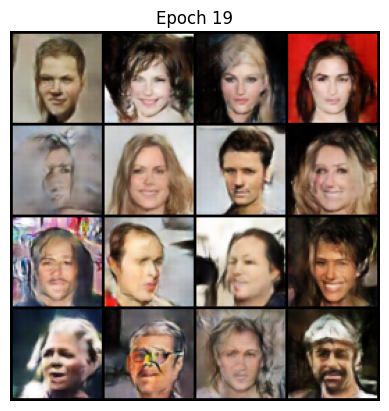

In [14]:
def train(generator, discriminator, dataloader, epochs=5):
    for epoch in range(epochs):
        for i, imgs in enumerate(dataloader):
            real_imgs = imgs.to(device)
            batch_size = real_imgs.size(0)
            valid = torch.ones(batch_size, 1).to(device)
            fake = torch.zeros(batch_size, 1).to(device)

            optimizer_D.zero_grad()
            real_loss = adversarial_loss(discriminator(real_imgs), valid)
            fake_loss = adversarial_loss(discriminator(generator(torch.randn(batch_size, 100,1,1).to(device)).detach()), fake)
            d_loss = (real_loss + fake_loss) / 2
            d_loss.backward()
            optimizer_D.step()

            optimizer_G.zero_grad()
            g_loss = adversarial_loss(discriminator(generator(torch.randn(batch_size, 100,1,1).to(device))), valid)
            g_loss.backward()
            optimizer_G.step()

            if i % 50 == 0:
                print(f"[Epoch {epoch}/{epochs}] [Batch {i}/{len(dataloader)}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]")

        save_generated_images(generator, epoch, device)

def save_generated_images(generator, epoch, device, num_images=16):
    z = torch.randn(num_images, 100,1,1).to(device)
    generated_imgs = generator(z).detach().cpu()
    grid = torchvision.utils.make_grid(generated_imgs, nrow=4, normalize=True)
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    plt.title(f"Epoch {epoch}")
    plt.axis('off')
    plt.show()

train(generator, discriminator, dataloader, epochs=20)
